<a href="https://colab.research.google.com/github/Samuscosta/machine-learning/blob/main/Myometrium_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ideia do projeto:
Facilitar a busca de células cancerígenas nos tecidos do útero, mais especificamente no miométrio

In [20]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import matplotlib.pyplot as plt
import numpy as np

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

Carregamento de dados

In [21]:
_URL = 'https://drive.google.com/u/0/uc?id=160Od2Gal-ccMznaUvGa7tw_qLpk8g5cx&export=download&confirm=t'
zip_dir = tf.keras.utils.get_file('myometrium_images.zip', origin=_URL, extract=True)

O dataset carregado possui a sequinte estrutura de diretórios:

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>myometrium_images</b>
|__ <b>train</b>
    |______ <b>leiomyoma</b>: [Leiomioma 40x001.jpg, Leiomioma 40x002.jpg, Leiomioma 40x003.jpg, ...]
    |______ <b>myometrium</b>: [Miométrio 40x001.png, Miométrio 40x002.png, Miométrio 40x003.png, ...]
|__ <b>validation</b>
    |______ <b>leiomyoma</b>: [Leiomioma 40x041.jpg, Leiomioma 40x042.jpg, Leiomioma 40x043.jpg, ...]
    |______ <b>myometrium</b>: [Miométrio 40x041.jpg, Miométrio 40x042.jpg, Miométrio 40x043.jpg, ...]
</pre>

É possível listar os diretórios com o comando de terminal:

In [22]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/myometrium_images
/root/.keras/datasets/myometrium_images/train
/root/.keras/datasets/myometrium_images/train/myometrium
/root/.keras/datasets/myometrium_images/train/leiomyoma
/root/.keras/datasets/myometrium_images/validation
/root/.keras/datasets/myometrium_images/validation/myometrium
/root/.keras/datasets/myometrium_images/validation/leiomyoma


Criação e atribuição de variáveis com os caminhos apropriados de treinamento e validação.

In [23]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'myometrium_images')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

HEALTH_FOLDER = "myometrium"
NOT_HEALTH_FOLDER = "leiomyoma"

train_health_dir = os.path.join(train_dir, HEALTH_FOLDER)  # directory with our training pictures
train_not_health_dir = os.path.join(train_dir, NOT_HEALTH_FOLDER)  # directory with our training pictures
validation_health_dir = os.path.join(validation_dir, HEALTH_FOLDER)  # directory with our validation pictures
validation_not_health_dir = os.path.join(validation_dir, NOT_HEALTH_FOLDER)  # directory with our validation pictures

In [24]:
num_health_tr = len(os.listdir(train_health_dir))
num_not_health_tr = len(os.listdir(train_not_health_dir))

num_health_val = len(os.listdir(validation_health_dir))
num_not_health_val = len(os.listdir(validation_not_health_dir))

total_train = num_health_tr + num_not_health_tr
total_val = num_health_val + num_not_health_val

In [25]:
print('Total training health myometrium images:', num_health_tr)
print('Total training NOT health myometrium images:', num_not_health_tr)

print('Total validation health myometrium images:', num_health_val)
print('Total validation NOT health myometrium images:', num_not_health_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

Total training health myometrium images: 42
Total training NOT health myometrium images: 49
Total validation health myometrium images: 10
Total validation NOT health myometrium images: 10
--
Total training images: 91
Total validation images: 20


In [26]:
BATCH_SIZE = 20  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 200  # Our training data consists of images with same number of pixels in width and height

In [27]:
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data

In [28]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE),
                                                           class_mode='binary')

Found 91 images belonging to 2 classes.


In [29]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE),
                                                              class_mode='binary')

Found 20 images belonging to 2 classes.


Visualizando imagens de treino

In [30]:
sample_training_images, _ = next(train_data_gen) 

In [31]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

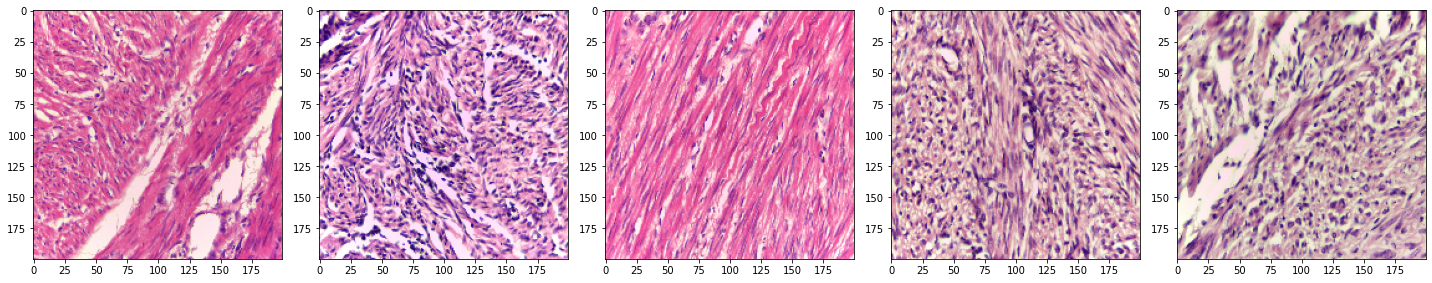

In [32]:
plotImages(sample_training_images[:5])  # Plot images 1-5

# Criação de modelo

In [33]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='valid'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='valid'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 99, 99, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 99, 99, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 49, 49, 64)       0         
 2D)                                                             
                                                      

Iniciando o treino

In [36]:
EPOCHS = 50

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
5/5 [==============================] - 19s 4s/step - loss: 0.9951 - accuracy: 0.5165 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/50
5/5 [==============================] - 17s 3s/step - loss: 0.6873 - accuracy: 0.5604 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/50
5/5 [==============================] - 17s 4s/step - loss: 0.6237 - accuracy: 0.6154 - val_loss: 0.6883 - val_accuracy: 0.5000
Epoch 4/50
5/5 [==============================] - 18s 4s/step - loss: 0.5508 - accuracy: 0.7582 - val_loss: 0.7218 - val_accuracy: 0.5000
Epoch 5/50
5/5 [==============================] - 17s 3s/step - loss: 0.4468 - accuracy: 0.8132 - val_loss: 0.6734 - val_accuracy: 0.5000
Epoch 6/50
5/5 [==============================] - 17s 3s/step - loss: 0.3425 - accuracy: 0.8901 - val_loss: 0.6740 - val_accuracy: 0.5000
Epoch 7/50
5/5 [==============================] - 16s 3s/step - loss: 0.4625 - accuracy: 0.8352 - val_loss: 1.0105 - val_accuracy: 0.5000
Epoch 8/50
5/5 [==================

Visualizando o resultado do treinamento

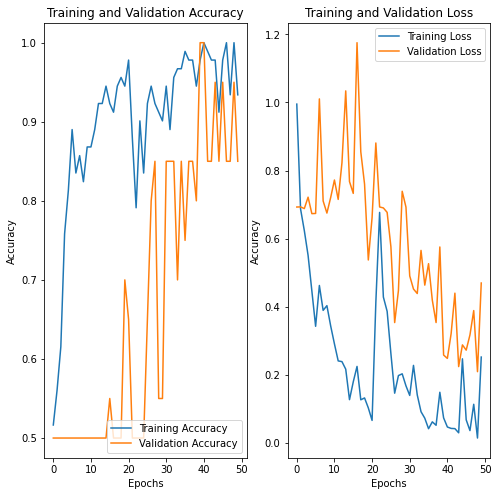

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.savefig('./foo.png')
plt.show()

In [38]:
print("Épocas trabalhadas:", EPOCHS)
print("Imagens para cada modelo: ", BATCH_SIZE)
print("Tamanho das imagens em pixel:", IMG_SHAPE)
print("\n")

avg_acc = sum(acc) / len(acc)
perc_avg_acc = avg_acc * 100
print("Média de acurácia de treino:", round(perc_avg_acc, 2))

avg_val_acc = sum(val_acc) / len(val_acc)
perc_avg_val_acc = avg_val_acc * 100
print("Média de acurácia de validação:", round(perc_avg_val_acc, 2))
print("\n")

avg_loss = sum(loss) / len(loss)
perc_avg_loss = avg_loss * 100
print("Média de perda de treino:", round(perc_avg_loss, 2))

avg_val_loss = sum(val_loss) / len(val_loss)
perc_avg_val_loss = avg_val_loss * 100
print("Média de perda de validação:", round(perc_avg_val_loss, 2))

Épocas trabalhadas: 50
Imagens para cada modelo:  20
Tamanho das imagens em pixel: 200


Média de acurácia de treino: 90.11
Média de acurácia de validação: 67.2


Média de perda de treino: 24.03
Média de perda de validação: 59.14
